In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATASET = "/home/cached/theCode/JupyterNotebooks/CloudClassification/Dataset"
CATEGORIES = ["Ci", "Cs", "Cc", "Ac", "As", "Cu", "Cb", "Ns", "Sc", "St", "Ct"]
# Ci Cs Cc Ac As Cu Cb Ns Sc St Ct

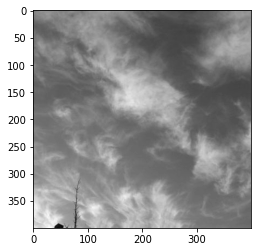

In [2]:
# Test Load
for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    for image in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
        
        # Check if we've loaded the images in properly
        plt.imshow(img_arr, cmap='gray')
        plt.show()
        break
    break

In [5]:
dataset = []

for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    img_cat = CATEGORIES.index(category)
    for image in os.listdir(path):
        # Load image in B/W
        img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
        # Insert into the dataset
        dataset.append([img_arr, img_cat])
        
# Print the dataset length to see if everything's here properly
print(len(dataset))

2543


In [ ]:
import random

random.seed(69) # Because reproducibility matters

'''
## Dataset Contents:
- Cirrus        (139 images)
- Cirrostratus  (287 images)
- Cirrocumulus  (268 images)
- Altocumulus   (221 images)
- Altostratus   (188 images)
- Cumulus       (182 images)
- Cumulonimbus  (242 images)
- Nimbostratus  (274 images)
- Stratocumulus (340 images)
- Stratus       (202 images)
- Contrails     (200 images)
Total :         2543 images

To balance the dataset, we'll assume that we need 350 images in each class (since max + 10)

So, extending this, each class requires
- Cirrus        (211 images)
- Cirrostratus  (063 images)
- Cirrocumulus  (082 images)
- Altocumulus   (129 images)
- Altostratus   (162 images)
- Cumulus       (168 images)
- Cumulonimbus  (108 images)
- Nimbostratus  (076 images)
- Stratocumulus (010 images)
- Stratus       (148 images)
- Contrails     (150 images)
Total :         3850 images

Note:
Since all we're doing is looking for patterns and not features, we're assuming that augmenting a class to
more than double the images it initially started off with won't have a serious impact on the final results.
This may/may not be a valid assumption, though. We'll only know for sure after training.
Also, since all we're looking for is a pattern, rotation and flipping don't make much sense. Same goes for
adding noise and blurring. And given how some images have buildings in the bottom, translating is also risky.
Hence, we're only cropping or resizing the images.
'''

def cropImg(x, y, arr):
    # Initialize an empty 300*300 list
    new_arr = [[0 for k in range(256)] for l in range(256)]
    # Yeet numbers into list for crop
    for i in range(x, x+256):
        for j in range(y, y+256):
            new_arr[x-i][y-j] = arr[i][j]
    return new_arr

random.shuffle(dataset)

# Set image dimensions
OLD_IMG_SIZE = 400
NEW_IMG_SIZE = 256

augmentable_count = {
    0  : 211,
    1  :  63,
    2  :  82,
    3  : 129,
    4  : 162,
    5  : 168,
    6  : 108,
    7  :  76,
    8  :  10,
    9  : 148,
    10 : 150
}

aug_data = []
index_errors = 0

# Augments the images
for img_arr, img_cat in dataset:
    try:
        if augmentable_count[img_cat] > 0:
            # Reduce count by 1, because we don't want infinite loops
            augmentable_count[img_cat] -= 1

            # Random number to figure out where we'll be cropping from or shrinking
            p = random.random()
            try:
                # Shrink Image (20%, since 5 cases)
                if p < (1/5):
                    new_img = cv2.resize(img_arr, (NEW_IMG_SIZE, NEW_IMG_SIZE))
                    aug_data.append([new_img, img_cat])

                # Crop from top (80 %, since it accounts for L and R (both top and bottom) )
                else:
                    x = random.randint(0, 144)
                    y = random.randint(0, 144)
                    new_img = cropImg(x, y, img_arr)
                    aug_data.append([new_img, img_cat])
                    
            # Image size is 256*256, not 400*400
            except IndexError:
                augmentable_count[img_cat] += 1
                index_errors += 1
                
    except KeyError:
        print("Key Error")
        print(augmentable_count)
        print(img_cat)
        plt.imshow(img_arr, cmap='gray')
        plt.show()
        print('---------------------------')
        
# Prints Dataset Size
print("Index Errors : ", index_errors)
print("Original Dataset : ", len(dataset))
print("Augmented Dataset: ", len(aug_data))
print(augmentable_count)

In [5]:
reshaped_data = []

# Convert images in Original into 256*256
for img_arr, cat_arr in dataset:
    new_img = cv2.resize(img_arr, (NEW_IMG_SIZE, NEW_IMG_SIZE))
    reshaped_data.append([new_img, img_cat])
    
# Join Original and Augmented together
training_data = reshaped_data + aug_data
print(len(training_data))

X = []
y = []

for features, label in training_data:
    X.append(features)
    foo = [0 for i in range(11)]
    foo[label] = 1
    y.append(foo)

X = np.array(X).reshape(-1, NEW_IMG_SIZE, NEW_IMG_SIZE, 1)

#print("Number of elements in the Dataset: ", len(X))

3778


In [6]:
# Import statements
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create the Model
num_classes = 11

model = keras.Sequential()

# Add preprocessing layer to convert from [0:255] to [0:1]
model.add(layers.experimental.preprocessing.Rescaling(
    1./255, 
    input_shape=(X.shape[1:])
        ))

# Add First Conv Layer, from Alex
# 256*256*1 to 63*63*64
model.add(layers.Conv2D(
    filters=64, 
    kernel_size=11, 
    strides=(4,4), 
    activation='relu')
         )

# Do some BatchNorm
model.add(keras.layers.BatchNormalization())
# Throw in a Max Pooling layer
# 63*63*64 to 31*31*64
model.add(layers.MaxPooling2D(
    pool_size=(3,3), strides=(2,2)
))

# Add second Conv Layer
# 31*31*64 to 31*31*256
model.add(layers.Conv2D(
    filters=224, 
    kernel_size=(5,5), 
    strides=(1,1), 
    activation='relu', 
    padding="same"
         ))
          
# Do some BatchNorm
model.add(keras.layers.BatchNormalization())
# Throw in a Max Pooling layer
# 31*31*224 to 15*15*224
model.add(layers.MaxPooling2D(
    pool_size=(3,3), strides=(2,2)
))

# Add another Conv2D layer
# 15*15*224 to 15*15*96
model.add(layers.Conv2D(
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation='relu',
    padding='same'
))

# Batch Norm is the norm
model.add(keras.layers.BatchNormalization())

# Add another Conv2D layer
# 15*15*96 to 15*15*32
model.add(layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1,1),
    activation='relu',
    padding='same'
))

# MaxPool layer
# 15*15*32 to 7*7*32
model.add(layers.MaxPooling2D(
    pool_size=(3,3), strides=(2,2)
))

# Time to go Flat
# 7*7*32 to 1568*1
model.add(layers.Flatten())

# Add a Dense layer
model.add(layers.Dense(768, 'relu'))
# Dropout
model.add(layers.Dropout(0.4))
# Another Dense Layer
model.add(layers.Dense(320, 'relu'))
# One Final Dropout
model.add(layers.Dropout(0.5))
# Output Layer
model.add(layers.Dense(11, 'softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 224)       358624    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 224)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 224)       0

In [1]:
Z = []
for i in X:
    Z.append(tf.convert_to_tensor(i, dtype=tf.float32))

X = Z
print(X[5])

# Train
#epochs = 5
#history = model.fit(X, y, batch_size=16, validation_split=0.2)

NameError: name 'X' is not defined

In [ ]:
# Analysis
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()